In [ ]:
# | default_exp analyses.omission_error_rate
%load_ext autoreload
%autoreload 2


# Omission Error Rate

In [ ]:
# | export

from typing import Optional, Sequence

import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap
from matplotlib import rcParams  # type: ignore
from matplotlib.axes import Axes

from jaxcmr.helpers import apply_by_subject, find_max_list_length
from jaxcmr.repetition import all_study_positions
from jaxcmr.plotting import init_plot, plot_data, set_plot_labels
from jaxcmr.typing import Array, Bool, Float, Integer, RecallDataset


We maintain this specialized implementation for time-sensitive use cases and demonstration purposes.

## Calculation

Sometimes participants study different items on each trial, or the same item might appear multiple times within a trial. To handle these cases, we use two arrays:

- `presentations`: Each row corresponds to a trial, and each column indicates which item was presented in each study position.
- `recalls`: Each row corresponds to a trial, and each column shows the item recalled by the participant in each output position.

In serial recall, we mark a recall as correct only if any of the study positions associated with the recalled item matches the current output position. We then calculate the accuracy at each position by determining how often participants correctly recalled that position across all trials. This gives us the **Serial Recall Accuracy Curve (SRAC)**, showing recall accuracy by position, even when lists differ or contain repetitions.

In [ ]:
# | exports

def trial_omission_error_rate(
    recalls: Integer[Array, " recall_positions"],
    presentations: Integer[Array, " study_positions"],
    size: int = 3,
) -> Bool[Array, " study_positions"]:
    # Expand each recall token into every study position it could refer to
    expanded_recalls = vmap(all_study_positions, in_axes=(0, None, None))(
        recalls, presentations, size
    )

    study_positions = jnp.arange(1, presentations.shape[0] + 1)

    # For each study position: did it ever appear in any expanded recall list?
    position_was_recalled = vmap(
        lambda pos: jnp.any(expanded_recalls == pos)
    )(study_positions)

    # Omission = never recalled AND study slot isn’t padding (presentation ≠ 0)
    return (~position_was_recalled) & (presentations != 0)


def omission_error_rate(
    recalls: Integer[Array, " trial_count recall_positions"],
    presentations: Integer[Array, " trial_count study_positions"],
    list_length: int,
    size: int = 3,
) -> Float[Array, " study_positions"]:
    """
    Returns position-specific recall accuracy, not assuming uniform study lists.

    Args:
        recalls: trial by recall position array of recalled items. 1-indexed; 0 for no recall.
        presentations: trial by study position array of presented items. 1-indexed.
        size: the number of studied items in each trial.
    """
    return vmap(trial_omission_error_rate, in_axes=(0, 0, None))(
        recalls,
        presentations,
        size,
    ).mean(axis=0)


## Plotting the Accurate Serial Position Curve

We can use a function analogous to our free recall plotting routine, but here it applies the `srac` or `fixed_pres_srac` under the hood. We'll call `srac` by default.

In [ ]:
# | exports


def plot_omission_error_rate(
    datasets: Sequence[RecallDataset] | RecallDataset,
    trial_masks: Sequence[Bool[Array, " trial_count"]] | Bool[Array, " trial_count"],
    color_cycle: Optional[list[str]] = None,
    labels: Optional[Sequence[str]] = None,
    contrast_name: Optional[str] = None,
    axis: Optional[Axes] = None,
) -> Axes:
    """
    Plots serial recall accuracy curve for one or more datasets.

    Args:
        datasets: Datasets containing trial data to be plotted.
        trial_masks: Masks to filter trials in datasets.
        color_cycle: List of colors for plotting each dataset.
        distances: Unused, included for compatibility with other plotting functions.
        labels: Names for each dataset for legend, optional.
        contrast_name: Name of contrast for legend labeling, optional.
        axis: Existing matplotlib Axes to plot on, optional.

    Returns:
        The matplotlib Axes object containing the plot.
    """
    axis = init_plot(axis)

    if color_cycle is None:
        color_cycle = [c["color"] for c in rcParams["axes.prop_cycle"]]

    if isinstance(datasets, dict):
        datasets = [datasets]

    if isinstance(trial_masks, jnp.ndarray):
        trial_masks = [trial_masks]

    if labels is None:
        labels = ["" for _ in datasets]

    # Identify the largest list length across datasets, so we can plot consistently
    max_list_length = find_max_list_length(datasets, trial_masks)

    for data_index, data_dict in enumerate(datasets):
        # We'll apply the accurate_spc function to each subject, then stack
        subject_values = jnp.vstack(
            apply_by_subject(
                data_dict,
                trial_masks[data_index],
                jit(omission_error_rate),
            )
        )

        # Plot
        color = color_cycle.pop(0)
        subject_values = subject_values[:, :max_list_length]
        xvals = jnp.arange(max_list_length) + 1
        plot_data(axis, xvals, subject_values, labels[data_index], color)

    set_plot_labels(axis, "Study Position", "Serial Recall Accuracy", contrast_name)
    return axis


## Tests

In [ ]:
def test_omission_no_omissions_even_with_repeats():
    presentations = jnp.array([[1, 2, 1]])
    recalls       = jnp.array([[1, 2, 1]])
    expected      = jnp.array([False, False, False])
    result = trial_omission_error_rate(recalls[0], presentations[0])
    assert jnp.array_equal(result, expected), result


def test_omission_single_missing_middle_item():
    presentations = jnp.array([[1, 2, 1]])
    recalls       = jnp.array([[1, 0, 0]])    # item “2” never recalled
    expected      = jnp.array([False, True, False])
    result = trial_omission_error_rate(recalls[0], presentations[0])
    assert jnp.array_equal(result, expected), result


def test_omission_none_with_multiple_repetitions():
    presentations = jnp.array([[1, 1, 2, 2]])
    recalls       = jnp.array([[1, 2, 0, 0]])  # both items recalled at least once
    expected      = jnp.array([False, False, True, True])
    result = trial_omission_error_rate(recalls[0], presentations[0])
    assert jnp.array_equal(result, expected), result


def test_omission_all_when_no_recalls():
    presentations = jnp.array([[3, 4, 5]])
    recalls       = jnp.array([[0, 0, 0]])
    expected      = jnp.array([True, True, True])
    result = trial_omission_error_rate(recalls[0], presentations[0])
    assert jnp.array_equal(result, expected), result


def test_omission_padding_ignored():
    presentations = jnp.array([[7, 0, 8]])     # list length 2, padded with 0
    recalls       = jnp.array([[0, 0, 0]])
    expected      = jnp.array([True, False, True])  # middle slot masked out
    result = trial_omission_error_rate(recalls[0], presentations[0])
    assert jnp.array_equal(result, expected), result


# run tests
test_omission_no_omissions_even_with_repeats()
test_omission_single_missing_middle_item()
test_omission_none_with_multiple_repetitions()
test_omission_all_when_no_recalls()
test_omission_padding_ignored()


## Examples

With real data, we would typically have a dictionary containing:
- `recalls`: a [trials x possibly_many_output_positions] array
- `pres_itemnos`: a [trials x list_length] array

Then we can use the provided plotting function to visualize position-wise accuracy for different conditions.

In [ ]:
import os

from jaxcmr.helpers import find_project_root, generate_trial_mask, load_data


Array([0.35714287, 0.4309524 , 0.49523813, 0.54761904, 0.5904762 ,
       0.61428577, 0.65000004, 0.6642857 , 0.6642857 , 0.70000005,
       0.6761905 , 0.6738095 , 0.6738095 , 0.6761905 , 0.70238096,
       0.6880953 , 0.6761905 , 0.70238096, 0.7214286 , 0.7285715 ,
       0.70952386, 0.7166667 , 0.7214286 , 0.6714286 , 0.71904767,
       0.66904765, 0.6714286 , 0.68333334, 0.6738095 , 0.6619048 ,
       0.6261905 , 0.6761905 , 0.63809526, 0.65952384, 0.6404762 ,
       0.6238096 , 0.60952383, 0.5761905 , 0.5857143 , 0.6547619 ],      dtype=float32)

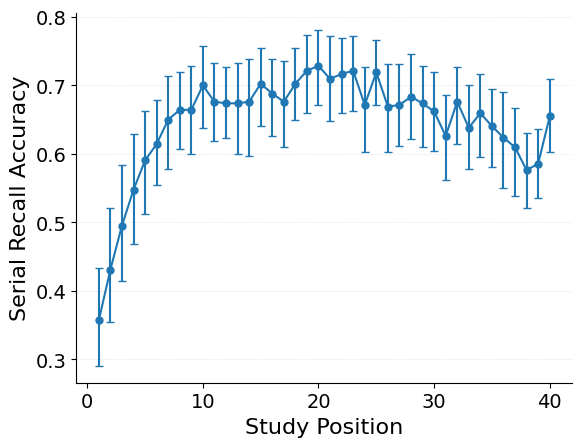

In [ ]:
# parameters
run_tag = "SRAC"
data_query = "data['list_type'] == 1"
data_path = os.path.join(find_project_root(), "data/LohnasKahana2014.h5")

# set up data structures
data = load_data(data_path)
recalls = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)

# plot
plot_omission_error_rate(data, generate_trial_mask(data, data_query))
jit(omission_error_rate)(recalls[trial_mask], presentations[trial_mask], list_length)


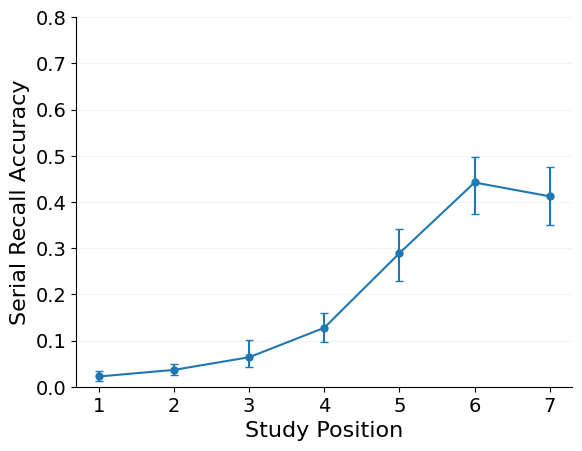

In [ ]:
# parameters
data_name = "Gordon2021"
data_query = "jnp.logical_and(data['condition'] == 2, data['listLength'] == 7)"
# data_query = "data['condition'] == 2"
data_path = os.path.join(find_project_root(), "data/Gordon2021.h5")

# set up data structures
data = load_data(data_path)
arr = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)

# plot
plot_omission_error_rate(data, generate_trial_mask(data, data_query))
omission_error_rate(arr[trial_mask], presentations[trial_mask], list_length)
plt.ylim(0, .8);


Array([0.01171875, 0.01736111, 0.01779514, 0.01475694, 0.01432292,
       0.03602431], dtype=float32)

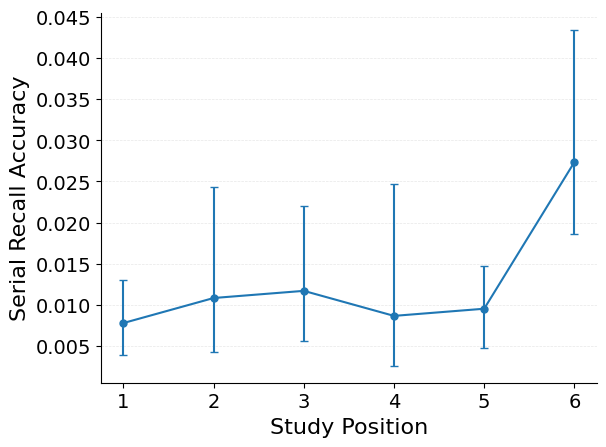

In [ ]:
# parameters
run_tag = "SRAC"
data_name = "GordonRanschburg2021"
data_query = "jnp.logical_and(data['condition'] == 1, data['lag'] != 4)"
# data_query = "data['condition'] == 2"
data_path = os.path.join(find_project_root(), "data/GordonRanschburg2021.h5")

# set up data structures
data = load_data(data_path)
arr = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)

# plot SPC
plot_omission_error_rate(data, generate_trial_mask(data, data_query))
omission_error_rate(arr[trial_mask], presentations[trial_mask], list_length)
# plt.ylim(0, 1);


data/KahanaJacobs2000.h5


/Users/jordangunn/jaxcmr/.venv/lib/python3.12/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/Users/jordangunn/jaxcmr/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


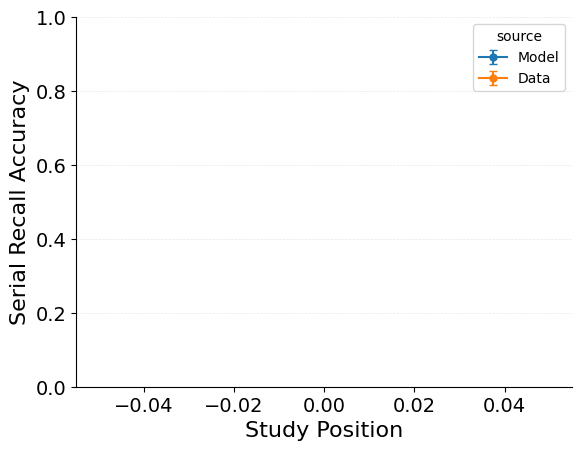

In [ ]:
# parameters
data_query = "jnp.logical_and(jnp.logical_and(jnp.logical_and(data['recall_attempt'] == 1, data['repetitions'] == 0), data['session'] <= 2), data['listLength'] == 13)"
# redo data query just using recall_attempt <= 2
run_tag = "SRAC"
dataset_paths = [
    "data/KahanaJacobs2000.h5",
    "fits/KahanaJacobs2000_WeirdCMR_full_best_of_3.h5",
    "fits/KahanaJacobs2000_WeirdNoReinstateCMR_full_best_of_3.h5",
    "fits/KahanaJacobs2000_WeirdPositionScaleCMR_full_best_of_3.h5",
    "fits/KahanaJacobs2000_OutlistCMRDE_full_best_of_3.h5",
    "fits/KahanaJacobs2000_WeirdDriftPositionScaleCMR_full_best_of_3.h5",
]

first_data = load_data(os.path.join(find_project_root(), dataset_paths[0]))
first_data_mask = generate_trial_mask(first_data, data_query)

for data_path in dataset_paths[:1]:
    print(data_path)

    # set up data structures
    data = load_data(os.path.join(find_project_root(), data_path))
    arr = data["recalls"]
    presentations = data["pres_itemnos"]
    list_length = data["listLength"][0].item()
    trial_mask = generate_trial_mask(data, data_query)

    # plot 
    plot_omission_error_rate(
        [data, first_data],
        [trial_mask, first_data_mask],
        labels=["Model", "Data"],
        contrast_name="source",
    )
    print(
        jit(omission_error_rate, static_argnames=("list_length"))(
            arr[trial_mask], presentations[trial_mask], list_length
        )
    )
    plt.ylim(0, 1)
    plt.show()
